# Machine Learning in business project

Selecting the Best Region for a New Oil Well

This project determines which region provides the highest expected profit with acceptable risk for developing new oil wells.

**Workflow:**
1. Data Loading & Exploration
2. Model Training & Evaluation
3. Break-even & Profit Preparation
4. Profit Function Implementation
5. Bootstrapping for Risk Assessment
6. Observations


In [1]:
#Load the Data
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

paths = {
    "region_0": "/datasets/geo_data_0.csv",
    "region_1": "/datasets/geo_data_1.csv",
    "region_2": "/datasets/geo_data_2.csv",
}

dfs = {k: pd.read_csv(v) for k, v in paths.items()}

print("Data summary by region:")
for name, df in dfs.items():
    print(f"\n{name} -> rows: {len(df)}, cols: {df.shape[1]}, missing: {df.isna().sum().sum()}")

    print(df.describe())

Data summary by region:

region_0 -> rows: 100000, cols: 5, missing: 0
                  f0             f1             f2        product
count  100000.000000  100000.000000  100000.000000  100000.000000
mean        0.500419       0.250143       2.502647      92.500000
std         0.871832       0.504433       3.248248      44.288691
min        -1.408605      -0.848218     -12.088328       0.000000
25%        -0.072580      -0.200881       0.287748      56.497507
50%         0.502360       0.250252       2.515969      91.849972
75%         1.073581       0.700646       4.715088     128.564089
max         2.362331       1.343769      16.003790     185.364347

region_1 -> rows: 100000, cols: 5, missing: 0
                  f0             f1             f2        product
count  100000.000000  100000.000000  100000.000000  100000.000000
mean        1.141296      -4.796579       2.494541      68.825000
std         8.965932       5.119872       1.703572      45.944423
min       -31.609576    

In [2]:
# Train model & evaluate
RANDOM_STATE = 42
SPLIT = 0.25
models = {}
val_predictions = {}
val_targets = {}

for name, df in dfs.items():
    X = df[["f0", "f1", "f2"]]
    y = df["product"]
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=SPLIT, random_state=RANDOM_STATE)
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_valid)
    rmse = mean_squared_error(y_valid, y_pred, squared=False)
    models[name] = model
    val_predictions[name] = pd.Series(y_pred, index=y_valid.index)
    val_targets[name] = y_valid
    print(f"\n{name} -> RMSE: {rmse:.2f}, mean_predicted: {y_pred.mean():.2f}, mean_actual: {y_valid.mean():.2f}")


region_0 -> RMSE: 37.76, mean_predicted: 92.40, mean_actual: 92.33

region_1 -> RMSE: 0.89, mean_predicted: 68.71, mean_actual: 68.73

region_2 -> RMSE: 40.15, mean_predicted: 94.77, mean_actual: 95.15


In [3]:
# Break-even calculation
BUDGET = 100_000_000
WELLS_TO_DEVELOP = 200
PRICE_PER_THOUSAND = 4500
BREAK_EVEN_PRODUCT = (BUDGET / WELLS_TO_DEVELOP) / PRICE_PER_THOUSAND
print(f"\nBreak-even threshold per well: {BREAK_EVEN_PRODUCT:.2f} thousand barrels")
for name, df in dfs.items():
    print(f"{name} mean product: {df['product'].mean():.2f} thousand barrels")


Break-even threshold per well: 111.11 thousand barrels
region_0 mean product: 92.50 thousand barrels
region_1 mean product: 68.83 thousand barrels
region_2 mean product: 95.00 thousand barrels



**Observations**    
The break-even production level is approximately 111.11 thousand barrels per well.
Comparing this threshold to the average reserves in each region:
    
* Region 0: 92.50 thousand barrels, below break-even, indicating potential risk of unprofitability without selecting the top-performing wells.
* Region 1: 68.83 thousand barrels, significantly below break-even, meaning only the very best wells would be profitable; high selectivity is essential.
* Region 2: 95.00 thousand barrels, still slightly below break-even, but closer to sustainable levels than Region 1.

*Interpretation:*
On average, none of the regions reach the break-even threshold across all wells. This means profitability will depend on identifying and developing only the top-performing wells within each region.
This analysis supports the next step — using the model predictions to find which specific wells (and which region) can deliver enough reserves to surpass the 111k-barrel threshold.


In [ ]:
# profit calculation
def calculate_profit(preds, targets, n_select=200):
    """
    Takes predictions and targets (already filtered/sampled if needed),
    selects top `n_select` wells by prediction,
    and calculates profit from the actual reserves.
    """
    top_idx = preds.sort_values(ascending=False).head(n_select).index
    total_product = targets.loc[top_idx].sum()
    profit = total_product * PRICE_PER_THOUSAND - BUDGET
    return profit

In [ ]:
print("Single-pass profit estimation using top 200 wells (one run):\n")

single_pass_results = {}

for name in dfs.keys():
    preds = val_predictions[name]
    targs = val_targets[name]

    # Top 200 wells by prediction (for reporting total reserves)
    top_idx = preds.sort_values(ascending=False).head(200).index
    total_product = targs.loc[top_idx].sum()

    # Profit using the same logic (top 200 inside the function)
    profit = calculate_profit(preds, targs)

    single_pass_results[name] = {
        "profit": profit,
        "total_product": total_product
    }

    print(
        f"{name}: total reserves = {total_product:.2f} thousand barrels, "
        f"profit = ${profit:,.0f}"
    )

Single-pass profit estimation using top 200 wells (one run):

region_0: total reserves = 29686.98 thousand barrels, profit = $33,591,411
region_1: total reserves = 27589.08 thousand barrels, profit = $24,150,867
region_2: total reserves = 27996.83 thousand barrels, profit = $25,985,718


Although Region 0 appears most profitable in this single pass, the true evaluation requires assessing average performance and downside risk over 1,000 randomized samples.

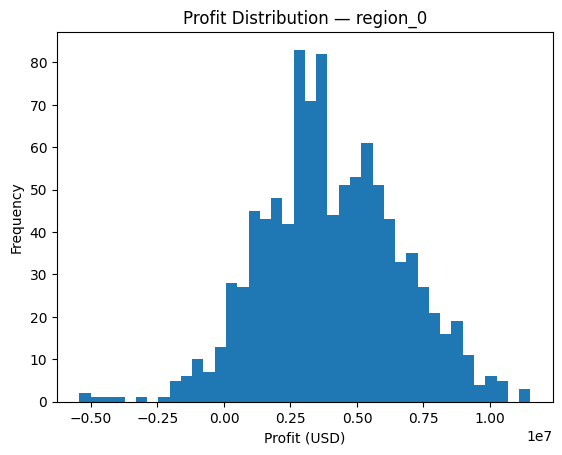

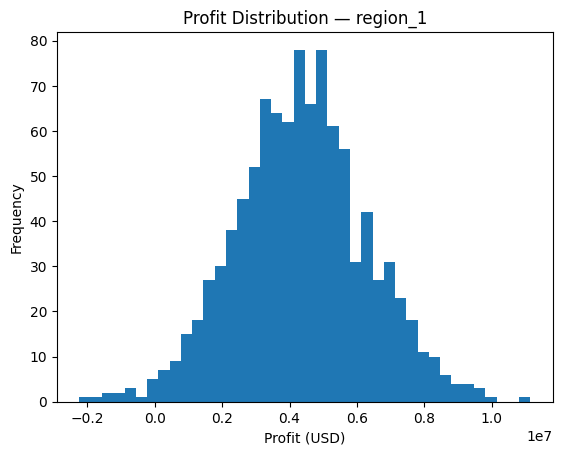

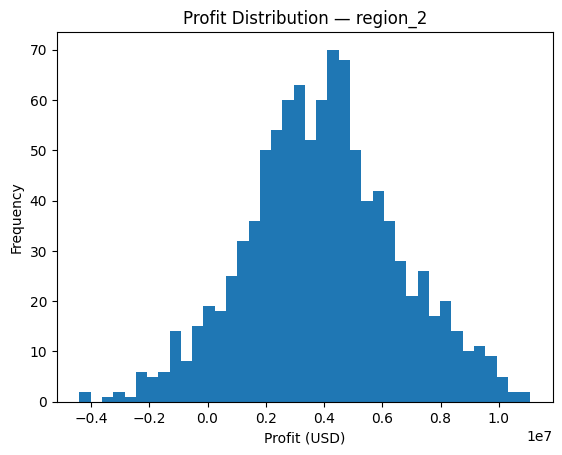


Bootstrap Results Summary:
region_0: avg=$4,040,225, CI=($-880,010, $9,125,599), loss risk=4.40%
region_1: avg=$4,350,616, CI=($567,629, $8,215,285), loss risk=1.30%
region_2: avg=$3,935,159, CI=($-1,235,798, $9,256,770), loss risk=6.60%


In [6]:
N_BOOT = 1000
POINTS_PER_REGION = 500  # sample size per iteration

def bootstrap_profit(preds, targets, n_boot=N_BOOT, sample_size=POINTS_PER_REGION):
    """
    Bootstrap process:
    1. Randomly sample 500 wells (simulate exploration)
    2. Profit function picks top 200 from those 500
    3. Compute profit using actual reserves
    """
    rng = np.random.default_rng(RANDOM_STATE)
    profits = []
    idx = preds.index.to_numpy()

    for _ in range(n_boot):
        # Step 1: sample 500 wells first
        sample_idx = rng.choice(idx, size=sample_size, replace=False)
        sample_preds = preds.loc[sample_idx]
        sample_targets = targets.loc[sample_idx]

        #pass those 500 to the profit function (select top 200)
        p = calculate_profit(sample_preds, sample_targets, n_select=200)
        profits.append(p)

    return np.array(profits)


# Run bootstrap for each region
results = {}

for name in dfs.keys():
    profits = bootstrap_profit(val_predictions[name], val_targets[name])
    results[name] = {
        "avg_profit": profits.mean(),
        "ci_low": np.percentile(profits, 2.5),
        "ci_high": np.percentile(profits, 97.5),
        "loss_risk_percent": (profits < 0).mean() * 100
    }

    # Plot distribution
    plt.figure()
    plt.hist(profits, bins=40)
    plt.title(f"Profit Distribution — {name}")
    plt.xlabel("Profit (USD)")
    plt.ylabel("Frequency")
    plt.show()


# Final printed summary
print("\nBootstrap Results Summary:")
for name, r in results.items():
    print(
        f"{name}: avg=${r['avg_profit']:,.0f}, "
        f"CI=(${r['ci_low']:,.0f}, ${r['ci_high']:,.0f}), "
        f"loss risk={r['loss_risk_percent']:.2f}%"
    )

**Observations**
    
* Region 1 has the highest average profit across 1,000 samples, outperforming both Regions 0 and 2.
* Region 1 also has the lowest loss risk (1.3%), well below the required 2.5% threshold.
* Its 95% confidence interval is entirely positive, indicating strong stability and low downside risk.
* Regions 0 and 2 have much higher volatility and both show negative lower bounds, meaning losses occur more frequently.

Region 1 is the optimal region for developing new oil wells.
It delivers the highest expected profit, the lowest probability of financial loss, and the most reliable performance across repeated sampling scenarios.


## Observations & Findings:
The goal of this project was to determine which of the three candidate regions offers the highest profit potential and lowest financial risk for new oil well development. A Linear Regression model was trained for each region to predict well reserves, and profitability was evaluated using both deterministic and bootstrapped simulations.

### The break-even threshold 
The break-even threshold for development is 111.11 thousand barrels per well.
Across all regions, the average well does not meet this threshold:
* Region 0 mean reserves: 92.50
* Region 1 mean reserves: 68.83
* Region 2 mean reserves: 95.00

This highlights the importance of relying on the model’s ability to identify high-performing wells, rather than depending on regional averages. Profitability depends entirely on selecting the best 200 wells from each region.

### Single-Pass Profit Analysis
Using the model’s predictions to select the top 200 wells from each region:
* Region 0: Profit ≈ $33.6M
* Region 1: Profit ≈ $24.2M
* Region 2: Profit ≈ $26.0M

Based on this single, deterministic selection, Region 0 appears most profitable.
However, this does not account for uncertainty in which wells would be available or explored in practice. A deeper evaluation using bootstrapping is required to measure risk.

### Bootstrapped Profit & Risk Evaluation (Step 5)

Using 1,000 iterations of randomly sampling 500 wells and selecting the top 200:
* Region 1 produces the highest average profit across repeated samples.
* Region 1 also has the lowest loss risk (1.3%), well below the 2.5% maximum allowed by the project.
* Region 1’s confidence interval is entirely positive, unlike Regions 0 and 2 which show negative lower bounds.
* Regions 0 and 2 show higher volatility and a much greater chance of losses.
Develop new wells in Region 1.

## Conclusion: Develop new wells in Region 1.
Even though Region 0 produced the highest profit in the single-pass test, the bootstrapped analysis (which simulates real exploration uncertainty) shows that Region 1 offers:
* the highest expected profit,
* the lowest probability of financial loss,
* the most stable and reliable outcomes, and
* performance that meets all project risk constraints.

Therefore, Region 1 is the optimal and safest investment decision for OilyGiant.